In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset
import os
import copy
from tensorboardX import SummaryWriter
from PIL import Image
import torchvision.transforms as transforms

plt.ion()   # interactive mode
%matplotlib inline

In [2]:
class KDEFDataset(Dataset):
    def __init__(self, root='D:\\Research\\data\\KDEF_and_AKDEF\\KDEF', transforms_=None, idx=[]):
        self.transform = transforms_
        self.files = []

        for path, subdirs, files in os.walk(root):
            for name in files:
                self.files.append(os.path.join(path, name))
        
        self.files =  [self.files[i] for i in idx]
        self.classes = {
             "AF":0,
             "AN":1,
             "DI":2,
             "HA":3,
             "NE":4,
             "SA":5,
             "SU":6
        }
        
        for index in range(4900):
            filepath = self.files[index % len(self.files)]
            filename = filepath.split('\\')[-1]
            if filename[4:6] not in self.classes:
                print(filepath)

    def __getitem__(self, index):
        filepath = self.files[index % len(self.files)]

        filename = filepath.split('\\')[-1]
        img = self.transform(Image.open(filepath))
        label = self.classes[filename[4:6]]

        return img, label

    def __len__(self):
        return len(self.files)

Load Data
---------


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

idx = np.random.permutation(4900)
idx = {'val': idx[0:490], 'train': idx[490:]}

dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=8,
                                             shuffle=True)
              for x in ['train', 'val']}

dataset_sizes = {x: len(idx[x]) for x in ['train', 'val']}
class_names = 7

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize a few images


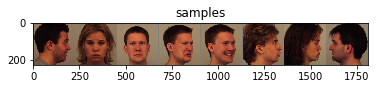

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title='samples')

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, dataloaders, writer=None, i=0,  num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'saved/resnet50_'+str(i)+'.pt')

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

Visualizing the model predictions

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [7]:
accuracies = []
index = list(np.random.permutation(4900))


for i in range(10):
    idx = {'val': index[490*i:490*(i+1)], 'train': index[:i*490]+index[((i+1)*490) -1:]}
 
    dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=32,
                                             shuffle=True)
              for x in ['train', 'val']}

    model_ft = models.resnet50(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, class_names)

    model_ft = model_ft.to(device)
 
    criterion = nn.CrossEntropyLoss()

    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)
    writer = SummaryWriter('./logs/resnet50_kfold_'+str(i))

    model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                     dataloaders, writer, i, num_epochs=20)
    
    accuracies.append(float(best_acc.data[0].cpu().numpy()))
    print("\n\n\n------------------------------------\n Accuracies ", accuracies)
    print("\n\n")

Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 1.5200 Acc: 0.4159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


val Loss: 0.8079 Acc: 0.7612

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:47<00:00,  1.29it/s]


train Loss: 0.5697 Acc: 0.8020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


val Loss: 0.4656 Acc: 0.8163

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:47<00:00,  1.28it/s]


train Loss: 0.3013 Acc: 0.9039


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.29it/s]


val Loss: 0.2919 Acc: 0.8959

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:45<00:00,  1.31it/s]


train Loss: 0.1909 Acc: 0.9356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


val Loss: 0.2581 Acc: 0.9204

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:45<00:00,  1.30it/s]


train Loss: 0.1205 Acc: 0.9621


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


val Loss: 0.2828 Acc: 0.9082

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:45<00:00,  1.31it/s]


train Loss: 0.0956 Acc: 0.9692


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


val Loss: 0.2604 Acc: 0.9102

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:44<00:00,  1.31it/s]


train Loss: 0.0641 Acc: 0.9812


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


val Loss: 0.1334 Acc: 0.9531

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:44<00:00,  1.32it/s]


train Loss: 0.0457 Acc: 0.9896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.27it/s]


val Loss: 0.1324 Acc: 0.9469

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:43<00:00,  1.33it/s]


train Loss: 0.0430 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1376 Acc: 0.9571

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0344 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.1361 Acc: 0.9510

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0342 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.1313 Acc: 0.9469

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:43<00:00,  1.33it/s]


train Loss: 0.0325 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1319 Acc: 0.9551

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:42<00:00,  1.35it/s]


train Loss: 0.0296 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.1419 Acc: 0.9551

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0325 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


val Loss: 0.1460 Acc: 0.9490

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.38it/s]


train Loss: 0.0289 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.28it/s]


val Loss: 0.1441 Acc: 0.9490

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0249 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.1340 Acc: 0.9490

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:43<00:00,  1.34it/s]


train Loss: 0.0257 Acc: 0.9968


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.1407 Acc: 0.9490

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0257 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


val Loss: 0.1276 Acc: 0.9571

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:42<00:00,  1.35it/s]


train Loss: 0.0258 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]


val Loss: 0.1205 Acc: 0.9551

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:42<00:00,  1.34it/s]


train Loss: 0.0277 Acc: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.1377 Acc: 0.9490

Training complete in 36m 46s
Best val Acc: 0.957143


C:\Users\bikas\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number





------------------------------------
 Accuracies  [0.9571428571428572]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:45<00:00,  1.31it/s]


train Loss: 1.5014 Acc: 0.4302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.29it/s]


val Loss: 0.8432 Acc: 0.6918

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:47<00:00,  1.29it/s]


train Loss: 0.5640 Acc: 0.8111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


val Loss: 0.5215 Acc: 0.8020

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:42<00:00,  1.35it/s]


train Loss: 0.3011 Acc: 0.8961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


val Loss: 0.4066 Acc: 0.8633

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:50<00:00,  1.25it/s]


train Loss: 0.1908 Acc: 0.9417


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.31it/s]


val Loss: 0.2981 Acc: 0.8816

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:45<00:00,  1.31it/s]


train Loss: 0.1217 Acc: 0.9626


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.33it/s]


val Loss: 0.3333 Acc: 0.8796

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:44<00:00,  1.32it/s]


train Loss: 0.0963 Acc: 0.9698


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.33it/s]


val Loss: 0.2337 Acc: 0.9224

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0557 Acc: 0.9864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1889 Acc: 0.9408

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0479 Acc: 0.9896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1595 Acc: 0.9490

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0443 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


val Loss: 0.1608 Acc: 0.9449

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:46<00:00,  1.29it/s]


train Loss: 0.0373 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.08it/s]


val Loss: 0.1583 Acc: 0.9449

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:47<00:00,  1.29it/s]


train Loss: 0.0352 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


val Loss: 0.1516 Acc: 0.9469

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:45<00:00,  1.31it/s]


train Loss: 0.0317 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.1843 Acc: 0.9449

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:44<00:00,  1.31it/s]


train Loss: 0.0306 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.1636 Acc: 0.9469

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.37it/s]


train Loss: 0.0258 Acc: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


val Loss: 0.1733 Acc: 0.9490

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:48<00:00,  1.27it/s]


train Loss: 0.0276 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.89it/s]


val Loss: 0.1441 Acc: 0.9551

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:57<00:00,  1.17it/s]


train Loss: 0.0323 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


val Loss: 0.1693 Acc: 0.9408

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:46<00:00,  1.30it/s]


train Loss: 0.0286 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


val Loss: 0.1606 Acc: 0.9510

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:45<00:00,  1.31it/s]


train Loss: 0.0280 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


val Loss: 0.1730 Acc: 0.9510

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:44<00:00,  1.33it/s]


train Loss: 0.0268 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.35it/s]


val Loss: 0.1477 Acc: 0.9510

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:42<00:00,  1.35it/s]


train Loss: 0.0257 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.33it/s]


val Loss: 0.1547 Acc: 0.9490

Training complete in 37m 29s
Best val Acc: 0.955102



------------------------------------
 Accuracies  [0.9571428571428572, 0.9551020408163267]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:43<00:00,  1.33it/s]


train Loss: 1.4718 Acc: 0.4304


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.34it/s]


val Loss: 0.7886 Acc: 0.7102

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:43<00:00,  1.33it/s]


train Loss: 0.5566 Acc: 0.8070


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.34it/s]


val Loss: 0.3708 Acc: 0.8837

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:42<00:00,  1.34it/s]


train Loss: 0.2831 Acc: 0.9023


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


val Loss: 0.2663 Acc: 0.9184

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:43<00:00,  1.34it/s]


train Loss: 0.1831 Acc: 0.9385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.35it/s]


val Loss: 0.2075 Acc: 0.9224

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:43<00:00,  1.34it/s]


train Loss: 0.1360 Acc: 0.9590


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.35it/s]


val Loss: 0.2113 Acc: 0.9306

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:43<00:00,  1.34it/s]


train Loss: 0.0937 Acc: 0.9726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


val Loss: 0.1669 Acc: 0.9388

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:42<00:00,  1.34it/s]


train Loss: 0.0528 Acc: 0.9878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


val Loss: 0.1224 Acc: 0.9592

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:43<00:00,  1.34it/s]


train Loss: 0.0370 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


val Loss: 0.1195 Acc: 0.9571

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:45<00:00,  1.31it/s]


train Loss: 0.0363 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


val Loss: 0.1186 Acc: 0.9592

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0364 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1125 Acc: 0.9592

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0304 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.1114 Acc: 0.9633

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0316 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.52it/s]


val Loss: 0.1101 Acc: 0.9633

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:38<00:00,  1.39it/s]


train Loss: 0.0252 Acc: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.1284 Acc: 0.9592

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0272 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1240 Acc: 0.9592

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 0.0270 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s]


val Loss: 0.1205 Acc: 0.9612

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 0.0268 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1166 Acc: 0.9592

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.38it/s]


train Loss: 0.0271 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1130 Acc: 0.9592

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 0.0247 Acc: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1271 Acc: 0.9571

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 0.0238 Acc: 0.9968


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1138 Acc: 0.9571

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0259 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.1117 Acc: 0.9571

Training complete in 36m 6s
Best val Acc: 0.963265



------------------------------------
 Accuracies  [0.9571428571428572, 0.9551020408163267, 0.9632653061224491]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 1.5072 Acc: 0.4295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.8494 Acc: 0.7000

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:38<00:00,  1.41it/s]


train Loss: 0.5607 Acc: 0.8054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.4656 Acc: 0.8633

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 0.2984 Acc: 0.8973


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.4129 Acc: 0.8408

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.1892 Acc: 0.9410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.2921 Acc: 0.9000

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.1189 Acc: 0.9619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.2940 Acc: 0.9102

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0990 Acc: 0.9692


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.2278 Acc: 0.9265

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 0.0579 Acc: 0.9846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1871 Acc: 0.9408

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:38<00:00,  1.40it/s]


train Loss: 0.0441 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.54it/s]


val Loss: 0.1814 Acc: 0.9449

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:37<00:00,  1.41it/s]


train Loss: 0.0391 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.56it/s]


val Loss: 0.1850 Acc: 0.9347

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:38<00:00,  1.41it/s]


train Loss: 0.0365 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.1738 Acc: 0.9469

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0340 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1891 Acc: 0.9388

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0301 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.1805 Acc: 0.9429

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0299 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.52it/s]


val Loss: 0.1694 Acc: 0.9469

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0288 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.1861 Acc: 0.9429

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0289 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.54it/s]


val Loss: 0.1891 Acc: 0.9408

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:38<00:00,  1.40it/s]


train Loss: 0.0273 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.56it/s]


val Loss: 0.1716 Acc: 0.9429

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0278 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.1786 Acc: 0.9469

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0245 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.1758 Acc: 0.9490

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 0.0250 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1878 Acc: 0.9449

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0262 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.1716 Acc: 0.9469

Training complete in 35m 14s
Best val Acc: 0.948980



------------------------------------
 Accuracies  [0.9571428571428572, 0.9551020408163267, 0.9632653061224491, 0.9489795918367347]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 1.5246 Acc: 0.4156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.8738 Acc: 0.6612

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.5613 Acc: 0.8102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.6192 Acc: 0.7776

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.2912 Acc: 0.9016


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.4401 Acc: 0.8286

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:38<00:00,  1.40it/s]


train Loss: 0.1842 Acc: 0.9447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.55it/s]


val Loss: 0.3744 Acc: 0.8755

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:38<00:00,  1.40it/s]


train Loss: 0.1248 Acc: 0.9610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.2798 Acc: 0.9041

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 0.0787 Acc: 0.9794


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.3157 Acc: 0.8980

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0504 Acc: 0.9887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.2158 Acc: 0.9245

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0393 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.2156 Acc: 0.9245

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0344 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.2060 Acc: 0.9388

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0326 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.52it/s]


val Loss: 0.2131 Acc: 0.9286

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0329 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.2094 Acc: 0.9327

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0270 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.52it/s]


val Loss: 0.1962 Acc: 0.9367

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 0.0264 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.2020 Acc: 0.9306

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0269 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.2053 Acc: 0.9265

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0261 Acc: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.2098 Acc: 0.9306

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0252 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.2096 Acc: 0.9286

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.38it/s]


train Loss: 0.0275 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.1961 Acc: 0.9408

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0261 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.2043 Acc: 0.9327

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 0.0259 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.2100 Acc: 0.9265

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 0.0243 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.2086 Acc: 0.9265

Training complete in 35m 20s
Best val Acc: 0.940816



------------------------------------
 Accuracies  [0.9571428571428572, 0.9551020408163267, 0.9632653061224491, 0.9489795918367347, 0.9408163265306123]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 1.5050 Acc: 0.4206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.56it/s]


val Loss: 0.7682 Acc: 0.7612

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:38<00:00,  1.40it/s]


train Loss: 0.5730 Acc: 0.8059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s]


val Loss: 0.4402 Acc: 0.8531

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.3118 Acc: 0.8957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.2678 Acc: 0.9061

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.1710 Acc: 0.9497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.3101 Acc: 0.8837

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.1377 Acc: 0.9562


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.2255 Acc: 0.9204

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0930 Acc: 0.9748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.4471 Acc: 0.8592

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0617 Acc: 0.9853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s]


val Loss: 0.1555 Acc: 0.9510

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0419 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.1447 Acc: 0.9510

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0375 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.1433 Acc: 0.9551

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:38<00:00,  1.40it/s]


train Loss: 0.0357 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.58it/s]


val Loss: 0.1379 Acc: 0.9551

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0297 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s]


val Loss: 0.1439 Acc: 0.9531

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0282 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.54it/s]


val Loss: 0.1381 Acc: 0.9551

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:38<00:00,  1.41it/s]


train Loss: 0.0276 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s]


val Loss: 0.1284 Acc: 0.9592

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0288 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.1394 Acc: 0.9571

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0289 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1403 Acc: 0.9531

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 0.0274 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.1423 Acc: 0.9551

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0256 Acc: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.52it/s]


val Loss: 0.1409 Acc: 0.9510

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0223 Acc: 0.9982


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1411 Acc: 0.9531

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0246 Acc: 0.9973


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.1353 Acc: 0.9510

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0246 Acc: 0.9968


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.1417 Acc: 0.9531

Training complete in 35m 13s
Best val Acc: 0.959184



------------------------------------
 Accuracies  [0.9571428571428572, 0.9551020408163267, 0.9632653061224491, 0.9489795918367347, 0.9408163265306123, 0.9591836734693878]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:38<00:00,  1.40it/s]


train Loss: 1.4861 Acc: 0.4361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.55it/s]


val Loss: 0.8580 Acc: 0.6898

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:38<00:00,  1.40it/s]


train Loss: 0.5534 Acc: 0.8095


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.4153 Acc: 0.8490

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.2774 Acc: 0.9098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.3076 Acc: 0.9041

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.1855 Acc: 0.9392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.3151 Acc: 0.8837

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.1567 Acc: 0.9467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.2754 Acc: 0.9082

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 0.0938 Acc: 0.9723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.2104 Acc: 0.9204

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0583 Acc: 0.9859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.1476 Acc: 0.9510

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0442 Acc: 0.9891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.1410 Acc: 0.9429

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:38<00:00,  1.39it/s]


train Loss: 0.0421 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.1347 Acc: 0.9469

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:37<00:00,  1.41it/s]


train Loss: 0.0367 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.1328 Acc: 0.9531

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 0.0306 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.52it/s]


val Loss: 0.1397 Acc: 0.9469

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0317 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.1423 Acc: 0.9551

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0261 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.1300 Acc: 0.9510

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0270 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.1453 Acc: 0.9469

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.39it/s]


train Loss: 0.0273 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.1615 Acc: 0.9388

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:38<00:00,  1.40it/s]


train Loss: 0.0259 Acc: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s]


val Loss: 0.1286 Acc: 0.9612

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0288 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1348 Acc: 0.9449

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:39<00:00,  1.38it/s]


train Loss: 0.0282 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.1330 Acc: 0.9531

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.38it/s]


train Loss: 0.0253 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1369 Acc: 0.9551

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.38it/s]


train Loss: 0.0260 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1344 Acc: 0.9449

Training complete in 35m 18s
Best val Acc: 0.961224



------------------------------------
 Accuracies  [0.9571428571428572, 0.9551020408163267, 0.9632653061224491, 0.9489795918367347, 0.9408163265306123, 0.9591836734693878, 0.9612244897959185]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 1.5051 Acc: 0.4351


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.8254 Acc: 0.7000

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.38it/s]


train Loss: 0.5631 Acc: 0.8082


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.6940 Acc: 0.7510

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.2962 Acc: 0.9059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.3257 Acc: 0.8776

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.1688 Acc: 0.9478


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.3082 Acc: 0.8959

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.38it/s]


train Loss: 0.1266 Acc: 0.9603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.2847 Acc: 0.8918

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.1001 Acc: 0.9676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


val Loss: 0.2546 Acc: 0.8980

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.38it/s]


train Loss: 0.0574 Acc: 0.9850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.1803 Acc: 0.9388

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0466 Acc: 0.9902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1746 Acc: 0.9347

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0386 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1786 Acc: 0.9408

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0330 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.1704 Acc: 0.9408

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0336 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.1653 Acc: 0.9429

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0269 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.1629 Acc: 0.9490

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0267 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.1615 Acc: 0.9510

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0249 Acc: 0.9971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.1734 Acc: 0.9388

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0273 Acc: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.1581 Acc: 0.9531

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0284 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.1524 Acc: 0.9449

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0266 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.1635 Acc: 0.9510

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0260 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.1562 Acc: 0.9449

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.37it/s]


train Loss: 0.0297 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1629 Acc: 0.9367

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0288 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.35it/s]


val Loss: 0.1659 Acc: 0.9408

Training complete in 35m 45s
Best val Acc: 0.953061



------------------------------------
 Accuracies  [0.9571428571428572, 0.9551020408163267, 0.9632653061224491, 0.9489795918367347, 0.9408163265306123, 0.9591836734693878, 0.9612244897959185, 0.953061224489796]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 1.5089 Acc: 0.4229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.8765 Acc: 0.6796

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.5602 Acc: 0.8095


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


val Loss: 0.4194 Acc: 0.8592

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.2931 Acc: 0.9027


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.3023 Acc: 0.8837

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.1739 Acc: 0.9454


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.2625 Acc: 0.9020

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.1198 Acc: 0.9649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.2410 Acc: 0.9265

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.1054 Acc: 0.9680


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.2248 Acc: 0.9224

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.37it/s]


train Loss: 0.0566 Acc: 0.9871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1876 Acc: 0.9408

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0435 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.1832 Acc: 0.9327

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0386 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.1770 Acc: 0.9429

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0341 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1862 Acc: 0.9388

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0370 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.1804 Acc: 0.9408

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0326 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1789 Acc: 0.9449

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.37it/s]


train Loss: 0.0296 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.1835 Acc: 0.9429

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.37it/s]


train Loss: 0.0275 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.1804 Acc: 0.9408

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0305 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.1842 Acc: 0.9429

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0280 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.1787 Acc: 0.9408

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0277 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1904 Acc: 0.9449

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0268 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


val Loss: 0.1832 Acc: 0.9429

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0254 Acc: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.1839 Acc: 0.9408

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0239 Acc: 0.9971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1892 Acc: 0.9408

Training complete in 35m 55s
Best val Acc: 0.944898



------------------------------------
 Accuracies  [0.9571428571428572, 0.9551020408163267, 0.9632653061224491, 0.9489795918367347, 0.9408163265306123, 0.9591836734693878, 0.9612244897959185, 0.953061224489796, 0.9448979591836736]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 1.5227 Acc: 0.4195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.9199 Acc: 0.6429

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.5744 Acc: 0.8068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


val Loss: 0.4594 Acc: 0.8286

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.37it/s]


train Loss: 0.2909 Acc: 0.9032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.3587 Acc: 0.8857

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.1914 Acc: 0.9376


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.3178 Acc: 0.8959

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.37it/s]


train Loss: 0.1289 Acc: 0.9617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.3086 Acc: 0.9061

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0921 Acc: 0.9719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.3565 Acc: 0.8735

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.37it/s]


train Loss: 0.0578 Acc: 0.9868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.1975 Acc: 0.9286

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0460 Acc: 0.9889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.1831 Acc: 0.9306

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0429 Acc: 0.9902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.2076 Acc: 0.9265

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0335 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.1970 Acc: 0.9245

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0353 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1997 Acc: 0.9286

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0296 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.1946 Acc: 0.9367

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0250 Acc: 0.9973


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.2031 Acc: 0.9327

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0271 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.1943 Acc: 0.9327

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0267 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.1848 Acc: 0.9367

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.37it/s]


train Loss: 0.0275 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.1874 Acc: 0.9367

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0243 Acc: 0.9980


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1976 Acc: 0.9367

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.36it/s]


train Loss: 0.0293 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.1908 Acc: 0.9347

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:41<00:00,  1.37it/s]


train Loss: 0.0275 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1933 Acc: 0.9347

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:40<00:00,  1.37it/s]


train Loss: 0.0258 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.1877 Acc: 0.9347

Training complete in 35m 55s
Best val Acc: 0.936735



------------------------------------
 Accuracies  [0.9571428571428572, 0.9551020408163267, 0.9632653061224491, 0.9489795918367347, 0.9408163265306123, 0.9591836734693878, 0.9612244897959185, 0.953061224489796, 0.9448979591836736, 0.9367346938775512]





# Load and test the model

In [8]:
model_ft.load_state_dict(torch.load('saved/resnet50_0.pt'))
model_ft.eval()

dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=index), batch_size=1,
                                             shuffle=True)
              for x in ['train', 'val']}

In [9]:
import imageio
total = 0
correct = 0

classes = {
    0 : "AF",
    1 : "AN",
    2 : "DI",
    3 : "HA",
    4 : "NE",
    5 : "SA",
    6 : "SU"
}

for inputs, labels in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    labels = labels.to(device)


    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    
    total+=1
    if labels.data[0].cpu().numpy() == preds.data[0].cpu().numpy():
        correct+=1
    else:
        # save the image
        img = inputs[0].cpu().numpy()
        img = np.ascontiguousarray(img.transpose(1,2,0))
        imageio.imwrite(str(total)+'.jpg', img)
        
        print("image no ", str(total), "  original class : ", classes[int(labels.data[0].cpu().numpy())], "  predicted class: ", classes[int(preds.data[0].cpu().numpy())])

print(correct, total)

  2%|█▌                                                                              | 93/4900 [00:01<01:34, 50.90it/s]

image no  98   original class :  AF   predicted class:  SA


  5%|███▉                                                                           | 248/4900 [00:04<01:30, 51.17it/s]

image no  250   original class :  HA   predicted class:  AN


  8%|██████                                                                         | 373/4900 [00:07<01:29, 50.59it/s]

image no  379   original class :  AF   predicted class:  SU


 12%|█████████▍                                                                     | 588/4900 [00:11<01:25, 50.65it/s]

image no  590   original class :  SA   predicted class:  AF


 15%|███████████▋                                                                   | 726/4900 [00:14<01:22, 50.75it/s]

image no  731   original class :  SA   predicted class:  NE


 15%|████████████                                                                   | 752/4900 [00:14<01:21, 50.62it/s]

image no  756   original class :  AF   predicted class:  SA


 17%|█████████████▋                                                                 | 851/4900 [00:16<01:19, 50.65it/s]

image no  856   original class :  AF   predicted class:  SA


 20%|███████████████▌                                                               | 969/4900 [00:19<01:17, 50.66it/s]

image no  975   original class :  NE   predicted class:  AN


 21%|████████████████▋                                                             | 1045/4900 [00:20<01:16, 50.62it/s]

image no  1049   original class :  AN   predicted class:  DI


 22%|█████████████████▏                                                            | 1078/4900 [00:21<01:15, 50.54it/s]

image no  1084   original class :  NE   predicted class:  SU


 23%|██████████████████▎                                                           | 1150/4900 [00:22<01:14, 50.54it/s]

image no  1151   original class :  NE   predicted class:  DI


 24%|██████████████████▌                                                           | 1167/4900 [00:23<01:13, 50.46it/s]

image no  1173   original class :  AF   predicted class:  SU


 25%|███████████████████▏                                                          | 1207/4900 [00:23<01:13, 50.42it/s]

image no  1211   original class :  SA   predicted class:  AN


 26%|███████████████████▉                                                          | 1253/4900 [00:24<01:12, 50.33it/s]

image no  1256   original class :  AF   predicted class:  SU


 35%|███████████████████████████                                                   | 1702/4900 [00:33<01:03, 50.42it/s]

image no  1705   original class :  HA   predicted class:  SU


 35%|███████████████████████████▍                                                  | 1720/4900 [00:34<01:03, 50.40it/s]

image no  1725   original class :  AF   predicted class:  DI


 37%|████████████████████████████▊                                                 | 1808/4900 [00:35<01:01, 50.38it/s]

image no  1810   original class :  SU   predicted class:  DI


 41%|███████████████████████████████▋                                              | 1988/4900 [00:39<00:57, 50.34it/s]

image no  1992   original class :  SA   predicted class:  AF


 41%|████████████████████████████████▎                                             | 2032/4900 [00:40<00:57, 50.31it/s]

image no  2038   original class :  AF   predicted class:  SU


 43%|█████████████████████████████████▌                                            | 2110/4900 [00:41<00:55, 50.36it/s]

image no  2116   original class :  SA   predicted class:  NE


 46%|███████████████████████████████████▊                                          | 2249/4900 [00:44<00:52, 50.32it/s]

image no  2254   original class :  AF   predicted class:  SA


 46%|███████████████████████████████████▉                                          | 2260/4900 [00:44<00:52, 50.30it/s]

image no  2264   original class :  SU   predicted class:  DI


 53%|█████████████████████████████████████████▌                                    | 2610/4900 [00:51<00:45, 50.40it/s]

image no  2612   original class :  AN   predicted class:  DI


 57%|████████████████████████████████████████████▎                                 | 2787/4900 [00:55<00:41, 50.36it/s]

image no  2789   original class :  AF   predicted class:  SU


 63%|████████████████████████████████████████████████▊                             | 3063/4900 [01:00<00:36, 50.45it/s]

image no  3069   original class :  AF   predicted class:  SU


 64%|█████████████████████████████████████████████████▊                            | 3127/4900 [01:02<00:35, 50.43it/s]

image no  3129   original class :  AF   predicted class:  SA


 65%|██████████████████████████████████████████████████▌                           | 3179/4900 [01:03<00:34, 50.45it/s]

image no  3184   original class :  HA   predicted class:  NE


 67%|████████████████████████████████████████████████████▍                         | 3298/4900 [01:05<00:31, 50.44it/s]

image no  3299   original class :  AF   predicted class:  AN


 71%|███████████████████████████████████████████████████████▌                      | 3493/4900 [01:09<00:27, 50.44it/s]

image no  3499   original class :  SA   predicted class:  AF


 72%|████████████████████████████████████████████████████████▍                     | 3547/4900 [01:10<00:26, 50.46it/s]

image no  3548   original class :  NE   predicted class:  SU


 73%|█████████████████████████████████████████████████████████▏                    | 3595/4900 [01:11<00:25, 50.46it/s]

image no  3596   original class :  AF   predicted class:  DI


 75%|██████████████████████████████████████████████████████████▋                   | 3684/4900 [01:13<00:24, 50.43it/s]

image no  3687   original class :  AN   predicted class:  DI


 79%|█████████████████████████████████████████████████████████████▊                | 3886/4900 [01:17<00:20, 50.46it/s]

image no  3891   original class :  AF   predicted class:  SU


 82%|███████████████████████████████████████████████████████████████▊              | 4005/4900 [01:19<00:17, 50.47it/s]

image no  4008   original class :  AF   predicted class:  SU


 84%|█████████████████████████████████████████████████████████████████▌            | 4119/4900 [01:21<00:15, 50.48it/s]

image no  4121   original class :  NE   predicted class:  DI


 86%|███████████████████████████████████████████████████████████████████▏          | 4220/4900 [01:23<00:13, 50.50it/s]

image no  4222   original class :  SU   predicted class:  AF


 88%|████████████████████████████████████████████████████████████████████▋         | 4316/4900 [01:25<00:11, 50.53it/s]

image no  4321   original class :  AN   predicted class:  DI


 93%|████████████████████████████████████████████████████████████████████████▋     | 4568/4900 [01:30<00:06, 50.58it/s]

image no  4571   original class :  SA   predicted class:  NE


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4663/4900 [01:32<00:04, 50.58it/s]

image no  4666   original class :  AF   predicted class:  SU


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4860/4900 [01:36<00:00, 50.56it/s]

image no  4861   original class :  AF   predicted class:  AN


100%|█████████████████████████████████████████████████████████████████████████████▋| 4878/4900 [01:36<00:00, 50.57it/s]

image no  4884   original class :  AF   predicted class:  HA


100%|██████████████████████████████████████████████████████████████████████████████| 4900/4900 [01:36<00:00, 50.57it/s]


4859 4900
